In [67]:
from mpl_toolkits.basemap import Basemap
import chart_studio.plotly as py
import plotly.graph_objs as go
import numpy as np           
from scipy.io import netcdf_file


In [68]:
f_path="/Users/new/Desktop/INFORMATIQUES/_Visualistion_de_données/Plotly/_data/compday.pqW831uq5f.nc"

In [69]:
with netcdf_file(f_path, 'r') as f:
    lon = f.variables['lon'][::]    # copy as list
    lat = f.variables['lat'][::-1]  # invert the latitude vector -> South to North
    air = f.variables['air'][0,::-1,:]  # squeeze out the time dimension, 
                                        # invert latitude index

/opt/anaconda3/envs/dashenv/lib/python3.9/site-packages/scipy/io/_netcdf.py:305: RuntimeWarning:

Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)



In [70]:
tmp_lon = np.array([lon[n]-360 if l>=180 else lon[n] 
                   for n,l in enumerate(lon)])  # => [0,180]U[-180,2.5]

i_east, = np.where(tmp_lon>=0)  # indices of east lon
i_west, = np.where(tmp_lon<0)   # indices of west lon
lon = np.hstack((tmp_lon[i_west], tmp_lon[i_east]))  # stack the 2 halves

# Correspondingly, shift the 'air' array
tmp_air = np.array(air)
air = np.hstack((tmp_air[:,i_west], tmp_air[:,i_east]))

In [71]:
trace1 = go.Contour(
    z=air,
    x=lon,
    y=lat,
    colorscale= [[0.0, '#171c42'], [0.07692307692307693, '#263583'], [0.15384615384615385, '#1a58af'], [0.23076923076923078, '#1a7ebd'], [0.3076923076923077, '#619fbc'], [0.38461538461538464, '#9ebdc8'], [0.46153846153846156, '#d2d8dc'], [0.5384615384615384, '#e6d2cf'], [0.6153846153846154, '#daa998'], [0.6923076923076923, '#cc7b60'], [0.7692307692307693, '#b94d36'], [0.8461538461538461, '#9d2127'], [0.9230769230769231, '#6e0e24'], [1.0, '#3c0911']],
    zauto=False,  # custom contour levels
    zmin=-5,      # first contour level
    zmax=5,        # last contour level  => colorscale is centered about 0
      
 
colorbar= {
    "borderwidth": 0, 
    "outlinewidth": 0, 
    "thickness": 15, 
    "tickfont": {"size": 14}, 
    "title": "°C"}, #gives your legend some units                                                                     

contours= {
    "end": 4, 
    "showlines": False, 
    "size": 0.5, #this is your contour interval
    "start": -4}     
    
)    


In [72]:
m = Basemap() 


In [73]:

# Make trace-generating function (return a Scatter object)
def make_scatter(x,y):
    return go.Scatter(
        x=x,
        y=y,
        mode='lines',
        line=Line(color="black"),
        name=' '  # no name on hover
    )

# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    # init. plotting list
    data = dict(
        x=[],
        y=[],
        mode='lines',
        line=dict(color="black"),
        name=' '
    )

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
    
        
        # add plot.ly plotting options
        data['x'] = data['x'] + lon_cc.tolist() + [np.nan]
        data['y'] = data['y'] + lat_cc.tolist() + [np.nan]
        
        # traces.append(make_scatter(lon_cc,lat_cc))
     
    return [data]

# Function generating coastline lon/lat traces
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

# Get list of of coastline, country, and state lon/lat traces


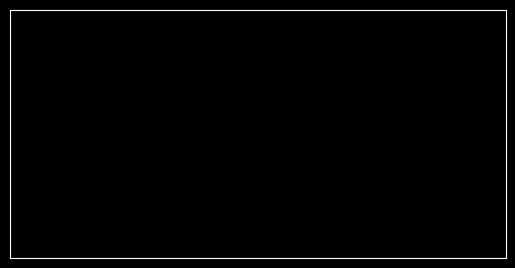

In [74]:
traces_cc = get_coastline_traces()+get_country_traces()

In [75]:
data = [trace1]+traces_cc

In [76]:

title = u"Surface Air Temperature Anomalies<br>Dec 2017-Jan 2018"

anno_text = "Data courtesy of \
<a href='http://www.esrl.noaa.gov/psd/data/composites/day/'>\
NOAA Earth System Research Laboratory</a>"

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)


In [80]:
fig = go.Figure(data=data)

fig.update_layout(
    template="plotly_dark",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        margin=dict(autoexpand=True, l=0, r=0, b=0),
    title=title,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=dict(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict y-axis to range of lon
    ),
    yaxis=dict(
        axis_style,
    ),
    
    annotations=[
        dict(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ],

    autosize=False,
    width=1200,
    height=800,
)